In [164]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import pandas as pd
from tqdm import trange
import time

# "Dictionary learning" for klassifiseringsproblemer
#### Bibian Eriksen, Marius Bjerke Stjernstedt og Karianne Strand Bergem

Maskinlæring er en form for kunstig intelligens som involverer å bygge algoritmer og modeller som kan lære og lage forutsigelser av data. I dette prosjektet skal vi se på en type maskinlæring kalt "dictionary learning", for å kunne klassifisere håndskrevende tall ved å bruke MNIST datasettet. Vi vil ta for oss to forskjellige måter å bruke "Dictionary learning" på, og se på problemer som oppstår underveis og hvordan løse dem.

<h1> Oppgave 1 </h1>

## a) 

"Singular Value Decomposition" (SVD) er en generalisering av matrisediagonalisering og kan brukes til å trene opp dictionaries fra data. Hver $m \times n$-matrise $A$ har en unik SVD 

$$A = U \Sigma V^T,$$

der $U$ er en ortogonal $m \times m$-matrise, $V$ er en ortogonal $n \times n$-matrise og $\Sigma$ er en rektangulær, diagonal $m \times n$-matrise som inneholder såkalte singulærverdier av $A$.

Vi ser først på testmatrisen $A_1$ fra oppgaveteksten og finner SVD-en med `np.linalg.svd`. Her har vi satt `full_matrices = False`, slik at overflødig informasjon ikke blir regnet ut. 

In [2]:
# Lager testmatrisen A_1
A1 = np.array([[1000,1],[0,1],[0,0]])

# Finner SVD
U,S,Vt = np.linalg.svd(A1, full_matrices = False)

# Printer A_1 og matrisene i SVD
print("\nFor matrise A_1:")
print(f"A1 =\n{A1}\n")
print(f"U = \n{U} \n")
print(f"S = \n{S}\n")
print(f"Vt = \n{Vt}\n")

# np.multiply ganger vektoren S inn i matrisen U kolonnevis
A1_rekonstruert = np.dot(np.multiply(U, S), Vt)

print(f"USVt = \n{A1_rekonstruert} \n")
print(np.allclose(A1, A1_rekonstruert)) # Vil gi True om matrisene er omtrent like




For matrise A_1:
A1 =
[[1000    1]
 [   0    1]
 [   0    0]]

U = 
[[ 1.e+00 -1.e-06]
 [ 1.e-06  1.e+00]
 [ 0.e+00  0.e+00]] 

S = 
[1.0000005e+03 9.9999950e-01]

Vt = 
[[ 0.9999995  0.001    ]
 [-0.001      0.9999995]]

USVt = 
[[ 1.00000000e+03  1.00000000e+00]
 [-2.18499053e-19  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]] 

True


Vi ser at matriseproduktet $U \Sigma V^T$ ikke er eksakt lik $A_1$ pga. flyttallsfeil, men `np.allclose()` gir "True". $U \Sigma V^T$ og $A_1$ er altså så å si like (innenfor en standard-toleranse 1e-08). 

Singulærverdiene er ordnet fra størst til minst, så den største verdien er i det øverste, venstre hjørnet av $\Sigma$ (i kodeblokken over er vektoren $S$ alle singulærverdiene som står på diagonalen til $\Sigma$, så i dette tilfellet er det snakk om den første verdien i $S$). Basisvektoren i $U$ som da er viktigst for å rekonstruere $A_1$ er den første kolonnen i $U$. Dette er fordi basisvektoren samsvarer med den første (og da største) singulærverdien i $\Sigma$. Ved en eventuell komprimering av SVD-matrisen, starter vi med å fjerne de laveste singulærverdiene og samsvarende basisvektorer først, da de største singulærverdiene er viktigst for å representere $A_1$. Ved å redusere SVD på denne måten fås en lav-rang rekonstruksjonen av $A_1$. Vi kommer tilbake til denne metoden i neste deloppgave. 

## b)

Videre finner vi også SVD for testmatrisen $A_2$.

In [3]:
# Lager testmatrise A_2
A2 = np.array([[1,0, 0],[1, 0, 0],[0,0, 1]])

# Finner SVD for A_2
U2,S2,Vt2 = np.linalg.svd(A2, full_matrices = False)

# Printer A_2 og matrisene i SVD
print("\nFor matrise A2:")
print(f"A2 =\n{A2}\n")
print(f"U = \n{U2} \n")
print(f"S = \n{S2}\n")
print(f"Vt = \n{Vt2}\n")


For matrise A2:
A2 =
[[1 0 0]
 [1 0 0]
 [0 0 1]]

U = 
[[-0.70710678  0.         -0.70710678]
 [-0.70710678  0.          0.70710678]
 [ 0.          1.          0.        ]] 

S = 
[1.41421356 1.         0.        ]

Vt = 
[[-1. -0. -0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]]



Når vi multipliserer $U$ og $\Sigma$ (dvs. når vi ganger singulærverdiene i vektoren $S$ kolonnevis inn i $U$), ser vi at den siste kolonnen i $U$ blir null, fordi den tredje singulærverdien i $\Sigma$ er null. Denne kolonnen vil derfor ikke gi noen relevant informasjon om matrisen $A_2$. Årsaken til at vi får en slik singulærverdi er at ikke alle kolonnene i $A_2$ er lineært uavhengige (som vi ser i $A_2$ av at andre kolonne er nullvektoren). Med andre ord, trenger vi egentig bare en $U$-matrise med $d=2$ (ikke $3$) basisvektorer. Vi kan konstruere en slik matrise ved å fjerne siste kolonne i $U$, og endre på de andre matrisene i samsvar med dette. 

$V^T$ er en $n \times n$-matrise (i dette tilfellet er $n=3$) og vi må derfor fjerne de $n-d$ siste radene i $V^T$ ($=1$, altså den siste raden). Fra $\Sigma$ fjerner vi singulærverdien $0$.

Denne metoden kalles redusert SVD. I neste kodeblokk bruker vi dette for å rekonstruere $A_2$. 



In [4]:
U_d = np.delete(U2, obj=2, axis=1) #sletter siste kolonne i U
#axis = 1 indikerer kolonne, 
#obj=2 betyr 2. kolonne
S_d = S2[0:2] #sletter siste element i S
Vt_d = np.delete(Vt2, obj=2, axis=0) #Sletter siste rad i Vt. axis = 0 indikerer rad.

#Skriver ut de modifiserte matrisene
print(f"U_d = \n{U_d} \n")
print(f"S_d = \n{S_d}\n")
print(f"Vt_d = \n{Vt_d}\n")

#Multipliserer matrisene med hverandre for å rekonstruere A2
A2_rekonstruert = np.dot(np.multiply(U_d, S_d), Vt_d)
print(f"U_d S_d Vt_d = \n{A2_rekonstruert} \n")
#print(np.dot(S_d, Vt_d))


U_d = 
[[-0.70710678  0.        ]
 [-0.70710678  0.        ]
 [ 0.          1.        ]] 

S_d = 
[1.41421356 1.        ]

Vt_d = 
[[-1. -0. -0.]
 [ 0.  0.  1.]]

U_d S_d Vt_d = 
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]] 



Her ser vi at den rekonstruerte $A_{2, \text{ rekonstruert}}$ er eksakt lik den opprinnelige $A_2$. Vi har altså ikke tapt noen informasjon om $A_2$ ved å fjerne den ene basisvektoren i $U$.

Under har vi skrevet en funksjon som lager en redusert SVD basert på en input av SVD-matrisene $U$ og $V^T$, vektoren $S$, samt antall ønskede basisvektorer $d$.  Den returnerer en dictionary $W = U_d$ (der $U_d$ er de $d$ første kolonnene i $U$), og vektene $H = \Sigma_d V^T_d$. $\Sigma_d$ er de $d$ første kolonnene og radene i $\Sigma$, og $V^T_d$  er de $d$ første radene i $V^T$. Det er viktig å passe på at $d$ ikke er større enn $m$ ettersom dette vil skape problemer over hvilke singulær- vektorer og verdier vi er ute etter å fjærne.



In [126]:
def truncSVD(U, S, Vt, d):
    """
    -----
    Inputs: 
    U = ortogonal mxm-matrise
    S = vektor som inneholder singulærverdiene til mxn-matrisen A
    Vt = ortogonal nxn-matrise
    d = antall basisvektorer i dictionarien W
    out = standardinstilling er "W&H", da returnerer funksjonen både W og H. 
          Ellers returneres bare W og verdien 0 for H. 
    -----
    Outputs:
    W = redusert dictionary (mxd-matrise)
    H = vektene (dxn-matrise)
    -----
    Beskrivelse:
    Regner ut redusert SVD
    """
    
    m = np.shape(U)[0] #m = antall rader i U
    n = np.shape(Vt)[0] #n = antall rader i Vt
    U_d = U[:, :-(m-d)] #Sletter de m-d siste kolonnene til U.
    S_d = S[0:d] #Sletter de siste objektene (0-ere) i S slik at S_d får lengde d.
    Vt_d = Vt[:-(n-d), :] #Sletter de siste n-d radene til Vt

    W = U_d
    H = np.multiply(S_d, Vt_d.T).T  #ganger inn singulærverdiene radvis i V_d og transponerer tilbake slik at vi får formen til Vt_d
    
    return W, H

In [6]:
#Tester funksjonen på A2

print(f"U_d fra 1b) = \n{U_d} \n")
W2, H2 = truncSVD(U2, S2, Vt2, 2)
print(f"W2 = \n{W2} \n")
print(f"H2 = \n{H2} \n")
print(f"W2 dot H2 = \n{np.dot(W2, H2)} \n")

U_d fra 1b) = 
[[-0.70710678  0.        ]
 [-0.70710678  0.        ]
 [ 0.          1.        ]] 

W2 = 
[[-0.70710678  0.        ]
 [-0.70710678  0.        ]
 [ 0.          1.        ]] 

H2 = 
[[-1.41421356 -0.         -0.        ]
 [ 0.          0.          1.        ]] 

W2 dot H2 = 
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]] 



Vi ser at $W_2$ er lik $U_d$ fra oppgave 1b), slik som forventet, og matrisemultiplikasjon av $W_2$ og $H_2$ gir $A_2$.

## c) 
Videre implementeres en funksjon som tar inn en dictionary med ortogonale kolonner og en matrise, og returnerer projeksjonen av kolonnene i matrisen på dictionarien slik

$$ P_W (B) = WW^TB, $$

der $P_W (B)$ er projeksjonen, $W$ er dictionarien og $B$ er matrisen. 

In [127]:
def orthproj(W, B):
    """
    -----
    Inputs: 
    W = dictionary (2D numpy-array)
    B = matrise (2D numpy-array)
    -----
    Outputs:
    proj = projeksjon (2D numpy-array, samme dimensjoner som B)
    -----
    Beskrivelse:
    Finner projeksjonen av kolonner i en matrise på en dictionary
    """
    # Finner W^T*B 
    Wt = W.transpose()
    Wt_B = np.dot(Wt,B)

    # Finner W*(W^T*B)
    proj = np.dot(W,Wt_B)

    return proj

In [128]:
# Lager testmatrisen B
B = np.array([[2, 0, 0],[1, 0, 1],[0, 1, 0]])

# Printer projeksjonen av testmatrisen B på dictionarien fra a)
print(f"P_W_1(B) = \n{orthproj(U, B)} \n")

# Printer projeksjonen av testmatrisen B på dictionarien fra b)
print(f"P_W_2(B) = \n{orthproj(W2, B)} \n")

P_W_1(B) = 
[[2.00000000e+00 0.00000000e+00 8.32531736e-23]
 [1.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]] 

P_W_2(B) = 
[[1.5 0.  0.5]
 [1.5 0.  0.5]
 [0.  1.  0. ]] 



Vi ser at projeksjonene av matrisen $B$ på de to dictionariene har lite eller ingen avvik fra elementene $B$, som gir mening da de er projeksjoner av nettopp denne matrisen. Samtidig stemmer det godt at når matrisen $B$ projiserer på $W_1$ at den ene kolonnen i projeksjonen blir nullvektoren da det bare trengs to kolonner for å beskrive projeksjonen ned på de to kolonnene i $W_1$. 

Deretter implementeres en funksjon som returnerer kolonnevise avstander fra $B$ til $W$. 

In [129]:
def coloumnwise_distance(W, B):
    """
    -----
    Inputs: 
    W = dictionary (2D numpy-array)
    B = matrise (2D numpy-array)
    -----
    Outputs:
    distance = distansen fra en matrise til en dictionary
               (1D numpy-array med lengde lik antall kolonner i B)
    -----
    Beskrivelse:
    Finner den kolonnevise distansen for en matrise til en dictionary
    """
    # Bruker np.linalg.norm med en passende "axis"
    proj_distance = orthproj(W, B)
    distance = np.linalg.norm(B - proj_distance, axis = 0)

    return distance

Regner ut projeksjonen av $B$ på hhv. dictionariene $W_1$ (utregnet fra matrisen $A_1$) og $W_2$ (utregnet fra matrisen $A_2$).


In [130]:
#Printer den projiserte matrisen B og matrisene A1 og A2.
print(f"A1 = \n{A1} \n")
print(f"A2 = \n{A2} \n")
print(f"B = \n{B} \n")

# Printer de kolonnevise distansene fra B til W1 fra A1
print(f"D_W1(B) = \n{coloumnwise_distance(U, B)} \n")

# Printer de kolonnevise distansene fra B til W2 fra A2
print(f"D_W2(B) = \n{coloumnwise_distance(W2, B)} \n")

A1 = 
[[1000    1]
 [   0    1]
 [   0    0]] 

A2 = 
[[1 0 0]
 [1 0 0]
 [0 0 1]] 

B = 
[[2 0 0]
 [1 0 1]
 [0 1 0]] 

D_W1(B) = 
[0.00000000e+00 1.00000000e+00 1.11022302e-16] 

D_W2(B) = 
[0.70710678 0.         0.70710678] 



Både den første og den siste kolonnen i $B$ ligger i det lineære spennet til kolonnene i $A_1$, så $D_U(B)$ gir en avstand tilnærmet $0$ fra disse kolonnene til $W_1$. Den andre kolonnen i $B$ ligger derimot ikke i dette planet, og avstanden er derfor større enn $0$.

Vi ser også at verken den første eller den siste kolonnen i $B$ ligger i spennet til $A_2$, og avstanden fra disse kolonnene til $W_2$ er derfor større enn $0$. Den midterste kolonnen til $B$ ligger åpenbart i spennet til $A_2$ (den er lik siste kolonne i $A_2$), og avstanden er derfor $0$.



## d)

Videre vil vi introdusere en annen måte å trene opp dictionaries. Et alternativ for SVD er "Exemplar-based Non-negative Matrix Factorization", ENMF. Dette går ut på at dersom vi har data fra en ikke-negativ matrise $A$, kan basisvektorene i den ikke-negative dictionarien $W_+$ velges som kolonner fra $A$. En ikke-negativ matrise er en matrise der hvert element er større eller lik null. Implementerer en funksjon som tar inn en ikke-negativ dictionary og en matrise, og returnerer den ikke-negative projeksjonen.

In [132]:
def nnproj(W, B, maxiter = 50, delta = 10**(-10)):
    """
    -----
    Inputs: 
    W = ikke-negativ dictionary
    B = matrise
    maxiter = maks antall iterasjoner
    delta = "safe-division factor"
    -----
    Outputs:
    nnDist = ikke-negativ projeksjon
    -----
    Beskrivelse:
    Finner den ikke-negative projeksjonen av B på W
    """
    # Initialiserer H+ med np.random.uniform
    H_k = np.random.uniform(0, 1, ((np.shape(W)[1]), np.shape(B)[1]))

    # Bruker iterasjonen vist i likning (20)
    Wt = W.transpose()
    Wt_B = np.dot(Wt,B)
    Wt_W = np.dot(Wt,W)

    for i in range(maxiter):
        H_k1 = (H_k * Wt_B) / (np.dot(Wt_W, H_k) + delta)
        H_k = H_k1

    nn_proj = np.dot(W, H_k1)
    
    return nn_proj, H_k

In [131]:
# Finner P^+_A1 (B) og P^+_A2 (B)
P_A1, H_A1 = nnproj(A1, B)
P_A2, H_A2 = nnproj(A2, B)


# Printer vektene og projeksjonene
print(f"B = \n{B} \n")
print(f"H^+_A1 = \n{H_A1} \n")
print(f"P^+_A1(B) = \n{P_A1} \n")
print(f"H^+_A2 = \n{H_A2} \n")
print(f"P^+_A2(B) = \n{P_A2} \n")

B = 
[[2 0 0]
 [1 0 1]
 [0 1 0]] 

H^+_A1 = 
[[0.00100137 0.         0.        ]
 [0.99908388 0.         0.5       ]] 

P^+_A1(B) = 
[[2.00045743 0.         0.5       ]
 [0.99908388 0.         0.5       ]
 [0.         0.         0.        ]] 

H^+_A2 = 
[[1.5 0.  0.5]
 [0.  0.  0. ]
 [0.  1.  0. ]] 

P^+_A2(B) = 
[[1.5 0.  0.5]
 [1.5 0.  0.5]
 [0.  1.  0. ]] 



Vi bekrefter at denne algoritmen fungerer ved å sjekke om projeksjonene gir mening. Projeksjonen skal være ikke-negativ og vi ser at alle elementene er større eller lik null. Projeksjonene er av matrisen $B$ så det skal være lite avvik fra elementene i $B$ slik som projeksjonene ved SVD. Vi ser her at elementene avviker noe mer enn ved projeksjon ved SVD, men stemmer likevel godt overens med matrisen $B$. Tilsvarende som for SVD stemmer det godt at når matrisen $B$ projiseres på $A_1$ at den ene kolonnen i projeksjonen blir nullvektoren da det bare trengs to kolonner for å beskrive projeksjonen ned på de to kolonnene i $A_1$.  

Videre implementeres en funksjon som finner den ikke-negative avstanden til matrisen $B$.

In [133]:
def nndist(W, B, maxiter = 50, delta = 10**(-10)):
    """
    -----
    Inputs: 
    W = ikke-negativ dictionary
    B = matrise
    maxiter = maks antall iterasjoner
    delta = "safe-division factor"
    -----
    Outputs:
    nnDist = ikke-negativ avstand
    -----
    Beskrivelse:
    Finner den ikke-negative avstanden fra B til dictionary W
    """
    proj_distance = nnproj(W, B, maxiter, delta)[0]
    nn_dist = np.linalg.norm(B - proj_distance, axis = 0)

    return nn_dist

In [134]:
D_A1 = nndist(A1, B)
D_A2 = nndist(A2, B)

#Printer den projiserte matrisen B og matrisene A1 og A2.
print(f"A1 = \n{A1} \n")
print(f"A2 = \n{A2} \n")
print(f"B = \n{B} \n")

# Printer de ikke-negative avstandene
print(f"D_A1(B) = \n{D_A1} \n")
print(f"D_A2(B) = \n{D_A2} \n")

A1 = 
[[1000    1]
 [   0    1]
 [   0    0]] 

A2 = 
[[1 0 0]
 [1 0 0]
 [0 0 1]] 

B = 
[[2 0 0]
 [1 0 1]
 [0 1 0]] 

D_A1(B) = 
[0.00158456 1.         0.70710678] 

D_A2(B) = 
[7.07106781e-01 1.00000008e-10 7.07106781e-01] 



Til forskjell fra da vi fant avstandene fra $B$ til $W_1$ og $W_2$ i oppgave 1c), ser vi her på om kolonnene i $B$ ligger i det $\textit{ikke-negative}$ spennet til hhv. $A_1$ og $A_2$. I forrige oppgave fikk vi at avstanden fra siste kolonne i $B$ til $W_1$ var $0$, siden denne kolonnen ligger i spennet til $A_1$. Denne kolonnen ligger derimot ikke i det ikke-negative spennet til $A_1$, og den ikke-negative avstanden til $A_1$ er derfor $\textit{ikke}$ $0$.

Noe mer her?

<h1> Oppgave 2 </h1>

Videre skal vi jobbe med større datasett. Filene `train.npy` og `test.npy` lastes opp, og dataene er lagret som `(number of pixels, number of classes, number of datapoints)`. Det er totalt $5000$ treningsdatapunkter og $800$ testdatapunkter for hver klasse.


## a)

Laster opp datasettene (bilder av siffer fra $0 - 9$) fra utdelt kode. 

In [33]:
# Laster opp data og skalerer om
train = np.load('train.npy')/255.0
test = np.load('test.npy')/255.0

# Shapes er (number of pixels, number of classes, number of data)
print(train.shape) # Burde bli (784,10,5000)
print(test.shape) # Burde bli (784,10,800)


(784, 10, 5000)
(784, 10, 800)


Nedenfor er en funksjon som plotter bilder på en grid (utdelt kode). 

In [119]:
def plotimgs(imgs, nplot = 4, figSize = 5):
    """
    -----
    Inputs: 
    imgs = (height*width,N) array som inneholder bilder, der N > nplot**2
    nplot = heltall, nplot**2 bilder plottes
    -----
    Beskrivelse:
    Plotter de nplot*nplot første bildene i imgs på en nplot x nplot grid.
    Antar height = width, og at bildene er lagret kolonnevis.
    """

    n = imgs.shape[1]
    m = int(np.sqrt(imgs.shape[0]))

    assert(n > nplot**2), "Trenger mengde data i matrise N > nplot**2"

    # Initialiserer subplots
    # fig = plt.figure(figsize=(figSize, figSize))
    fig, axes = plt.subplots(nplot,nplot, figsize=(figSize, figSize))

    # Setter bakgrunnsfarge
    plt.gcf().set_facecolor("lightgray")

    # Itererer over bildene
    for idx in range(nplot**2):

        # Break hvis vi går utenfor array
        if idx >= n:
            break

        # Indekser
        i = idx//nplot; j = idx%nplot

        # Fjerner akse
        axes[i,j].axis('off')

        axes[i,j].imshow(imgs[:,idx].reshape((m,m)), cmap = "gray")
    
    # Plott

    fig.tight_layout()
    plt.show()


Plotter de $16$ første bildene av heltallet $5$ på en $4 \times 4$ grid med `train[:,5,:]`.

(784, 5000)


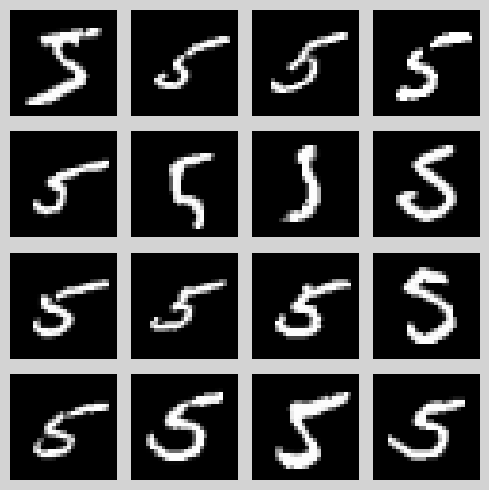

In [27]:
# Plotter de 16 første bildene av 5
print(np.shape(train[:,5,:]))
plotimgs(train[:,5,:], nplot = 4)

## b)

Finner så SVD $A_{test} = U \Sigma V^T$, der $A_{test}$ er matrisen som inneholder et datasett av sifferet $5$ vi valgte i a) kolonnevis. $A_{test}$ inkluderer kun data fra bilder av dette sifferet. Vi plotter de første $d = 16$ venstre singulære vektorene av $A_{test}$, som er kolonnene i $U_d$. Plotter også de singulære verdiene fra høyest til lavest der $y$-aksen er logaritmisk.

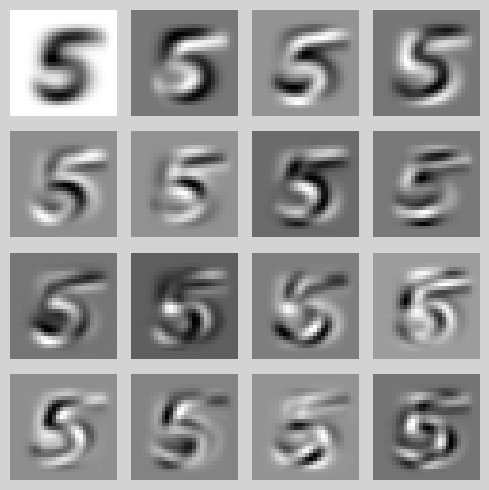

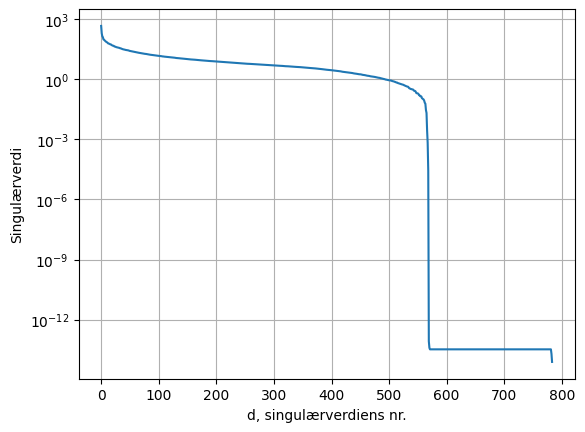

In [155]:
n_dat = 5000 # Antall datapunkter

#Lager et treningsett for siffer 5 med n_dat datapunkter
A_test = train[:,5,:n_dat]


# Henter ut U, Sigma og Vt og plotter U for de første 16 bildene av 5
U_test,Sig_test,Vt_test = np.linalg.svd(A_test, full_matrices = False)
plotimgs(U_test, nplot = 4)

# Plotter singulærverdiene opp mot x (der x er nummereringen til singulærverdiene, 
# i synkende rekkefølge) med en logaritmisk y-akse
plt.semilogy(Sig_test)
plt.xlabel("d, singulærverdiens nr.")
plt.ylabel("Singulærverdi")
plt.grid()
plt.show()

Hvert siffer vil ha karakteristiske trekk som gjør det mulig å skille dem fra hverandre, men det kan likevel i noen tilfeller være vanskelig å klassifisere dem riktig. Karakteristiske trekk går igjen for flere tall, for eksempel den skrå streken i siffer $2$ og $7$. Singulære vektorer i dictionary $U$ sammen med singulærverdiene $\Sigma$ er begge er sortert fra mest til minst viktig mot høyre.

Vi bruker sifferet $5$ til å se på hvordan basisvektorer i $U$ representerer de viktigste karakteristiske egenskapene for sifferet $5$ for tillhørende singulærverdier i $\Sigma$. I det første plottet ovenfor vises de første $16$ basisvektorene fra venstre i $U$. Dette er de viktigste vektorene for å representere bildene av sifferet $5$. 

Vi ser at grafen faller raskt, med ca. $1$ størrelsesorden, helt i begynnelsen (i et område der $d$ tilsynelatende er under $10$), før den avtar med en jevnere hastighet. Vi kan se at dette samsvarer i forhold til hva vi ser i $U$-plottene. Videre er det et slakt bånd ned til singulærverdi $500$ som vil inneholder relevante verdier for å rekonstruere A. Ved singulærverdi nummer $560-580$, faller størrelsesordenen til singulærverdiene drastisk til rundt $10^{-14}$. Vi kan anta at disse verdiene egentlig er $0$-ere, der disse små verdiene skyldes numeriske feil. Basisvektorene i $U$ som hører til disse singulærverdiene er derfor helt unødvendige og tilfører ingen ny informasjon om $A_{test}$.

Vi vil i mange tilfeller også være interessert i en teoretisk modell for å finne det optimale antall basisvektorer $d$ som vi ønsker å beholde uten å miste for mye informasjon. Det å finne den optimale verdien av $d$ er en krevende oppgave som vanligvis ikke har noe fasitsvar, men i  en rapport av M. Gavish & D. L. Donoho $^{[2]}$ er det diskutert og forklart hvordan man kan finne den optimale reduksjonsfaktoren for en rektangulær matrise $A$ som inneholder en ukjent mengde flyttallsfeil i $\Sigma$ (støy). Dette utrykkes ved $d_{opt}$ $=$ $\omega$($\beta$) $\cdot$ $y_{median}$, der $d_{opt}$ er den optimale mengden med basisvektorer, $y_{median}$ er medianverdien til av alle singulærverdiene i $\Sigma$, og $\omega$($\beta$) kan for enkelthetensskyld utrykkes slik,
$$
\omega(\beta) \cong 0.56\beta^3 - 0.95\beta^2 +1.82\beta + 1.43
$$
der $\beta = m/n$ som dimensjoner til $A$. Hvis vi tar i bruk dette finner vi at for tilfellet over vil vi få en optimal $d$ på ca. $5$ basisvektorer. Vi ser at dette kan godt stemme utifra $U$ plottene og det første falle i plottet av $\Sigma$ sine singulærverdier. 

Vi ser videre at ved å plotte de $16$ første basisvektorene i $U$ for de første sifrene i treningssettet, bærer dette god informasjon for å kunne gjenkjenne sifferet $5$. Fra plottene ser vi hvordan informasjonen for å representere sifferet $5$ blir dårligere og dårligere. Når vi ser på plottet til $\Sigma$, ser vi at dette samsvarer med "styrken" til samsvarende singulærverdi. $U$-plottene blir vanskelige å tolke rundt $12$ basisvektor som også virker reellt i forhold til $\Sigma$ sin verdi rundt singulærverdi nummer $12$. 

## c)

Videre finner vi den ortogonale projeksjonen $P_W(b)$ der $b$ er et bilde av heltallet $5$ ($b$ er altså én kolonne i A) , der $W = U_d$ med $d = 16, 32, 64,128$. Resultatene plottes sammen med det originale bildet.  

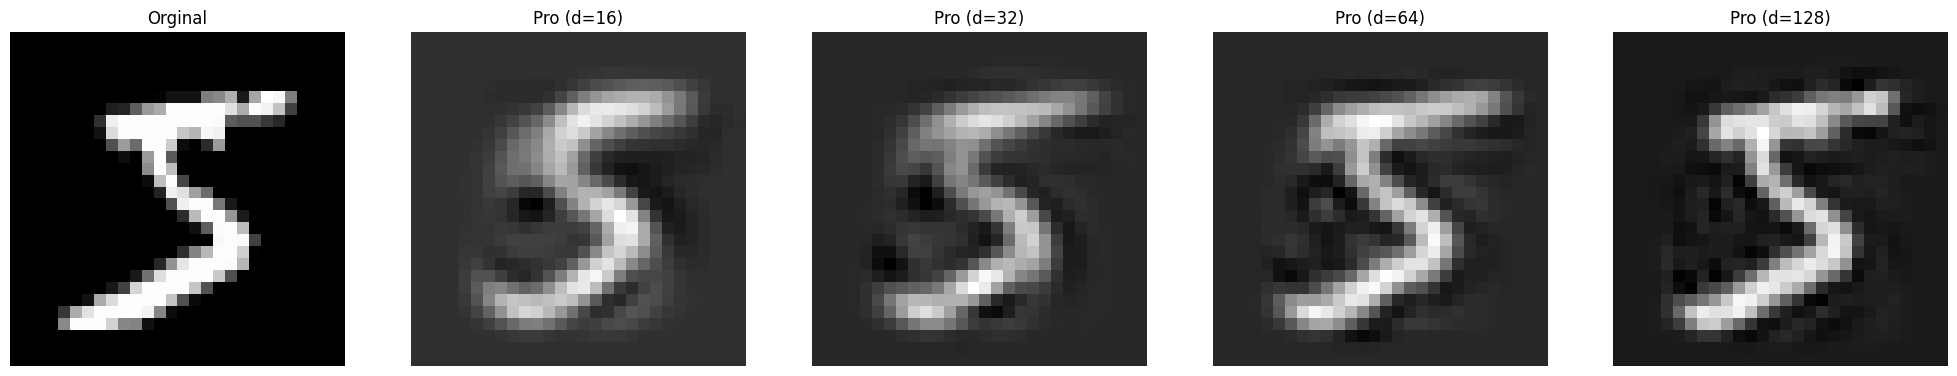

In [88]:
B_arr = train[:, 5, 0]


fig = plt.figure(figsize=(25, 25))

#Plotter 1. siffer 5 sammen med projeksjonen av W på dette bildet
ax = fig.add_subplot(151, title='Orginal', aspect='equal')
Org = ax.imshow(train[:, 5, 0].reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(152, title='Pro (d=16)', aspect='equal')
pro = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 16)[0], B_arr).reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(153, title='Pro (d=32)', aspect='equal')
Org = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 32)[0], B_arr).reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(154, title='Pro (d=64)', aspect='equal')
Org = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 64)[0], B_arr).reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(155, title='Pro (d=128)', aspect='equal')
Org = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 128)[0], B_arr).reshape((28,28)), cmap = 'gray')
plt.axis('off')

plt.show()

Med en dictionary som er trent på bilder av sifferet $5$, øker kvaliteten på rekonstruksjonen av bildet (som er av et 5-tall) med økende $d$, og allerede ved $d = 128$ likner tallet godt på det opprinnelige bildet. 

I neste kodeblokk gjør vi det samme eksperimentet med et bilde $\tilde{b}$ som er av heltallet $3$, noe $W$ ikke er trent på.

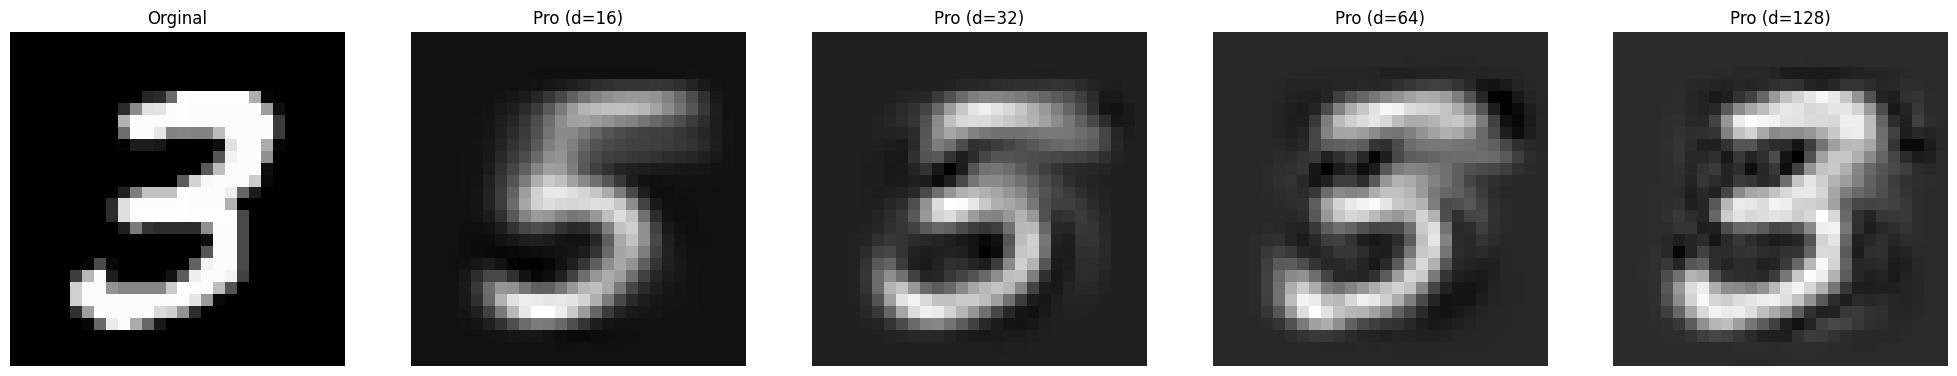

In [89]:
num = 3
B_arr3 = train[:, num, 0]


fig = plt.figure(figsize=(25, 25))

#Plotter 1. siffer 5 og projeksjonen av W ned op 1. siffer 3
ax = fig.add_subplot(151, title='Orginal', aspect='equal')
Org = ax.imshow(train[:, num, 0].reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(152, title='Pro (d=16)', aspect='equal')
pro = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 16)[0], B_arr3).reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(153, title='Pro (d=32)', aspect='equal')
Org = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 32)[0], B_arr3).reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(154, title='Pro (d=64)', aspect='equal')
Org = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 64)[0], B_arr3).reshape((28,28)), cmap = 'gray')
plt.axis('off')

ax = fig.add_subplot(155, title='Pro (d=128)', aspect='equal')
Org = ax.imshow(orthproj(truncSVD(U_test, Sig_test, Vt_test, 128)[0], B_arr3).reshape((28,28)), cmap = 'gray')
plt.axis('off')

plt.show()

Når vi projiserer et annet siffer på $W$ enn sifferet som $W$ er basert på, her sifferet $3$, vil rekonstruksjonen ved små $d$ fortsatt ligne sifferet som $W$ er trent på. Det kreves en høy $d$ for at $3$-tallet skal synes, og likevel blir kvaliteten relativt dårlig. 

## d)

Videre skal vi kvantitativt undersøke hva som skjer når $d$ øker ved å regne ut $\lvert \lvert A - P_W(A) \rvert \rvert^2_F$ for $d \in [1, 784]$. Her refererer $\lvert \lvert . \rvert \rvert_F$ til Frobenius-normen, som er en måte å måle avstanden mellom 2 matriser på. 
I kodeblokken under lager vi et datasett `A_test3` som inneholder 1000 bilder av 3-tall, samt et datasett `A_test5` som inneholder 1000 bilder av 5-tall. Deretter projiserer vi både `A_test3` og `A_test5` ned på en SVD-dictionary $W$ som er regnet ut fra `A_test5`. Dette gjøres med økende antall basisvektorer $d$.

In [156]:
# Henter ut dict for 1000 elementer for siffer 6
n = 1000 # Number of datapoints

# Henter treningstada for siffer 3 og 5 med n datapunker
A_test3 = train[:,3,:n]
A_test5 = train[:,5,:n]
###---------------

d_list = np.linspace(1, 784, 50, dtype=np.int64) #Lager en liste med 20 d verdier av helttall mellom 1 og 784


U_test5,Sig_test5,Vt_test5 = np.linalg.svd(A_test5, full_matrices = False) # Henter ut U, Sigma og Vt for 0 og 1 dict

# Lager arrays som inneholder Frobenius-avstanden avhenging av antall basisvektorer
norm_F_5 = np.zeros(len(d_list), dtype=float)
norm_F_no5 = np.zeros(len(d_list), dtype=float)
for i in range(len(d_list)-1):
    norm_F_5[i] = np.linalg.norm(A_test5 - orthproj(truncSVD(U_test5, Sig_test5, Vt_test5, d_list[i])[0],A_test5), 'fro')**2
    norm_F_no5[i] = np.linalg.norm(A_test3 - orthproj(truncSVD(U_test5, Sig_test5, Vt_test5, d_list[i])[0],A_test3), 'fro')**2


Vi plotter den kvadrerte Frobenius-avstanden mellom `A_test5` og $P_W(A_{test5})$ som funksjon av $d$, og gjør tilsvarende for `A_test3` og $P_W(A_{test3})$.

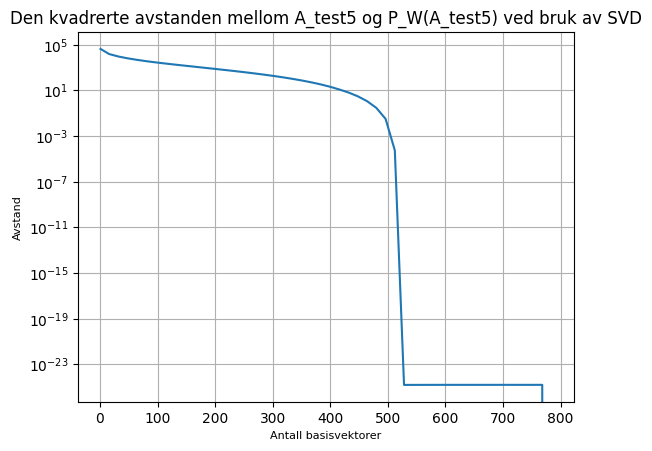

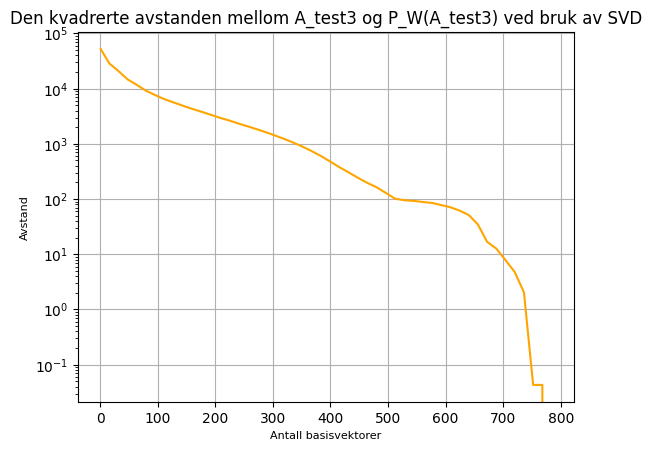

In [102]:
# Avstanden mellom testdata for siffer 6 og projeksjonen av vektene på disse 
plt.semilogy(d_list, norm_F_5)    
plt.title("Den kvadrerte avstanden mellom A_test5 og P_W(A_test5) ved bruk av SVD")
plt.xlabel("Antall basisvektorer", fontsize=8)
plt.ylabel("Avstand", fontsize=8)
plt.grid()
plt.show()
# Avstanden mellom testdata for siffer 2 og prosjeksjonen av vektene for siffer 6 ned på testdata for siffer 2
plt.semilogy(d_list, norm_F_no5, color = 'orange')  
plt.title("Den kvadrerte avstanden mellom A_test3 og P_W(A_test3) ved bruk av SVD")
plt.xlabel("Antall basisvektorer", fontsize=8)
plt.ylabel("Avstand", fontsize=8)
plt.grid()
plt.show()

Vi ser i begge plott at å øke antall basisvektorer reduserer avstanden mellom $A$ og $P_W(A)$. I det første plottet, ser vi at avstanden synker drastisk til $0$ (tilnærmet, sett bort ifra flyttallssfeil) når antall basisvektorer er i overkant av $500$. På dette tidspunktet vil altså $P_W(A_{test5})$  perfekt representere $A_{test5}$. Dette stemmer godt overens med resultatene vi fikk i oppgave b), der vi så at singulærverdiene ble $0$ når $d$ var et sted mellom $500$ og $600$. Etter denne $d$-verdien vil ikke flere basisvektorer gi noen ekstra informasjon som kan brukes til å rekonstruere $A_{test5}$, noe som gir mening siden $A_{test5}$ her vil være perfekt rekonstruert og ingen ny info vil forbedre resultatet (dvs. redusere avstanden).

Når vi projiserer et annet siffer (her: $3$) ned på dictionarien som er tiltenkt $5$-tall, ser vi i nederste plott at avstanden mellom projeksjonen og det opprinnelige bildet avtar saktere enn det gjorde når $W$ og $A$ var basert på samme siffer. Mens den kvadrerte avstanden mellom $P_W(A_{test5})$ og $A_{test5}$ er redusert til $10^1$ ved ca. $d=430$, trengs det rundt $d=700$ basisvektorer før $\lvert A_{test5} - P_W(A_{test5}) \rvert \rvert^2_F$ er redusert til det samme. Vi ser også at selv om denne avstanden aldri helt blir redusert til $0$ (den miste kvadrerte avstanden er i underkant av $10^{-1}$), vil likevel projeksjonen bli relativt god med et høyt antall basisvektorer. Vi vil derfor kunne få en ok rekonstruksjon av et $3$-tall ved bruk av en dictionary som er trent på $5$-tall hvis vi har en stor nok $d$.

## e)

Vi vil nå ta for oss ENMF-tilnærmingen. Funksjonen nedenfor tar inn testmatrisen $A_{\text{test}}$ med $n$ datapunkter, og lager en dictionary $W$ der basisvektorene er $32$ tilfeldig valgte kolonner fra $A_{\text{test}}$. Deretter projiseres $A_{\text{test}}$ på $W$. Funksjonen returnerer projeksjonen $P$ samt dictionarien $W$.

In [136]:
def ENMF_dicts(A, d):
    """
    -----
    Inputs: 
    A = array med n datapkt fra en valgt klasse. shape: (784, n) {784 rader, n kolonner, 1 kolonne = 1 bilde}
    d = int mellom 1 og 1000, antall basisvektorer i W
    -----
    Outputs:
    P = ikke-negativ projeksjon av A på W (W er d tilfeldig valgte kolonner av A)
    -----
    Beskrivelse:
    Lager ENMF dictionary for datasett for et bestemt siffer og kalkulerer projeksjonen av dictionary på datasettet
    """
    n = A.shape[1] #antall kolonner i A (dvs. antall datapkt/bilder)
    W = np.zeros((784, d)) #tom matrise med d kolonner
    rand_indexes = np.random.choice(n,d, replace=False)  #genererer d tilfeldige indekser mellom 0 og n
    for i in range(len(rand_indexes)):
       W[:, i] = A[:, rand_indexes[i]]  #legger til d tilfeldige kolonner fra A kolonnevis i W
    P = nnproj(W, A)[0]  #projiserer den ikke-negative projeksjonen av A på W 

    
    return P, W

Vi plotter så de 16 første projeksjonene av datasettet `A_test` (5000 datapunkter for sifferet 5) ned på ENMF-dictionarien med $d=32$. Under dette plotter vi også 16 projeksjoner der vi har brukt en SVD-dictionary, for sammenligning.

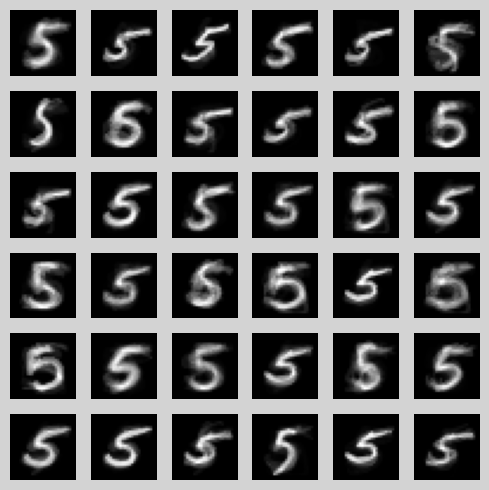

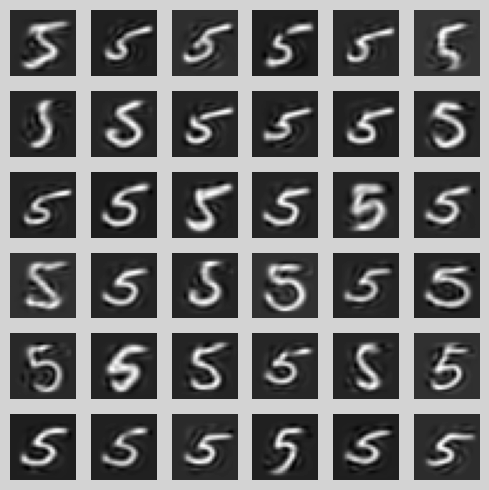

In [113]:
# Plotter 16 ENMF-projeksjoner
ENMF_proj32 = ENMF_dicts(A_test, 64)[0]
plotimgs(ENMF_proj32, nplot = 6)


# Plotter SVD-projeksjoner
W_SVD = truncSVD(U_test, Sig_test, Vt_test, 64)[0] #Hentet fra SVD-beregning av A_test fra oppg. 2b
plotimgs(orthproj(W_SVD, A_test), nplot=6)

Vi ser at ENMF gir plott med tydeligere konstraster - bakgrunnen er helt svart. Dette skyldes at ENMF bruker faktiske bilder som eksisterer i `A_test` som basisvektorer, så en lineærkombinasjon av disse vil gi et helt svart piksel der alle basisvektorene har svarte piksler - noe som er tilfelle i utkanten av hvert bilde (der det ikke er tegnet et 5-tall). Vi kan også se antydninger til hvilke bilder som har blitt brukt som basisvektorer, ved at det er mulig å se at hver rekonstruksjon er flere bilder av et 5-tall lagt oppå hverandre.

Med SVD har vi derimot en utydeligere grå-aktig bakgrunn, og noen rare mønstre rundt 5-tallet. Dette kommer av at SVD-basisvektorene er utregnet, og disse vil derfor inneholde numeriske feil ("støy"). 

## f)

Vi plotter deretter ENMF med et økende antall basisvektorer $d$. Vi bruker 10 $d$-verdier som er logaritmisk skalert mellom 1 og 1000.

Original


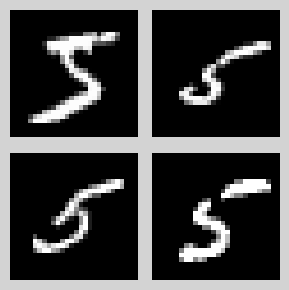

d = 10


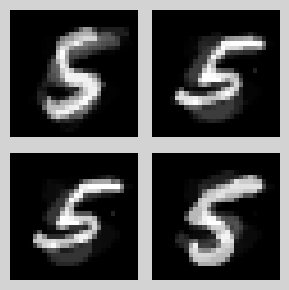

d = 16


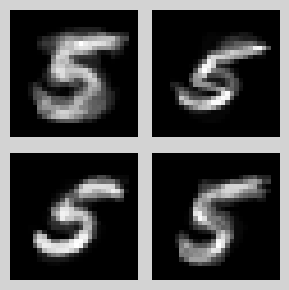

d = 27


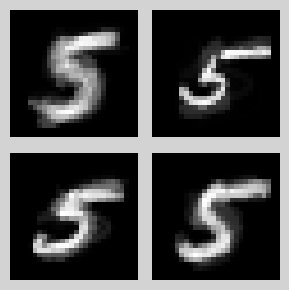

d = 46


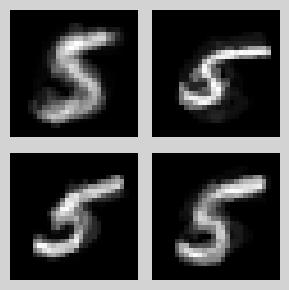

d = 77


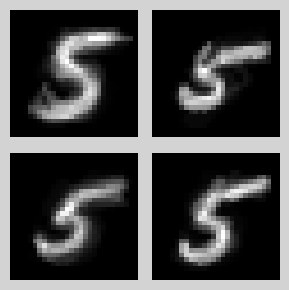

d = 129


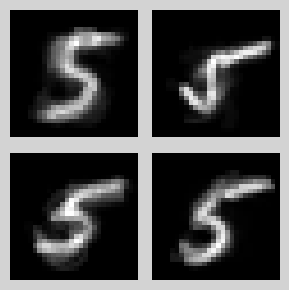

d = 215


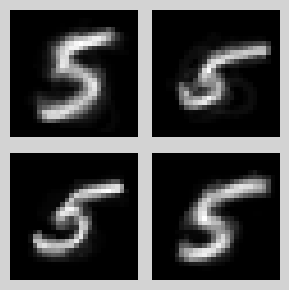

d = 359


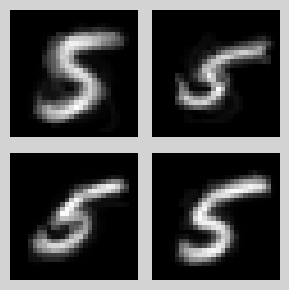

d = 599


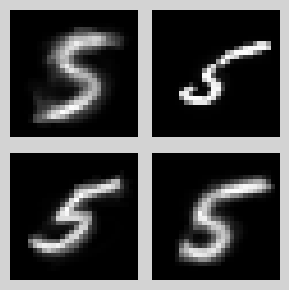

d = 1000


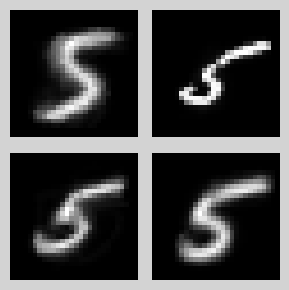

In [110]:
d_vals = np.logspace(1, 3, 10, dtype = np.int64) #lager 10 d-verdier, logaritmisk skalert mellom 1 og 1000
print("Original")
plotimgs(A_test, nplot = 2, figSize = 3)

for n in range(len(d_vals)): #her: 10 ganger
    ENMF_proj = ENMF_dicts(A_test, d_vals[n])[0]
    print(f"d = {d_vals[n]}")
    plotimgs(ENMF_proj, nplot = 2, figSize = 3)

Her ser vi at projeksjonene blir bedre når man øker antall basisvektorer. Det er også størst forskjell når man øker $d$ fra et lite tall til et litt større tall, men endringene avtar etterhvert. Det er f.eks. større forskjell på $d = 10$ og $d = 16$ enn det er på $d = 599$ og $d = 1000$. 

Vi ser også at vi av og til får en perfekt rekonstruksjon av originalbildet (se f.eks. bildet i øverste høyre hjørne for $d = 599$ og $d = 1000$). Dette er en konsekvens av at vi velger $d$ tilfeldige bilder fra $A_{\text{test}}$ som basis. At rekonstruksjonen er identisk betyr bare at bildet vi har plottet tilfeldigvis er et av bildene som ble valgt som basisvektor i $W$. Med $d=1000$ er 20 % av vektorene i $A_{\text{test}}$ blitt brukt som basisvektor, og at en av disse er et av de 4 bildene som skal rekonstrueres, er derfor ikke usannsynlig.

<h1> Oppgave 3 </h1>




Klassifisering går ut på å kategorisere observasjoner inn i klasser. I denne oppgaven ønsker vi å kategorisere bildene som et heltall mellom $0$ til $9$. Hvert heltall utgjør altså en klasse. Nedenfor genereres et testsett, og funksjonen testes. Det plottes datapunkter og deres korresponderende klasse.

In [117]:
# Funksjon som kom med oppgavefilene
def generate_test(test, digits = [0,1,2], N = 800):
    """
    Randomly generates test set.
    input:
        test: numpy array. Should be the test data loaded from file
        digits: python list. Contains desired integers
        N: int. Amount of test data for each class
    output:
        test_sub: (784,len(digits)*N) numpy array. Contains len(digits)*N images
        test_labels: (len(digits)*N) numpy array. Contains labels corresponding to the images of test_sub
    """

    assert N <= test.shape[2] , "N needs to be smaller than or equal to the total amount of available test data for each class"

    assert len(digits)<= 10, "List of digits can only contain up to 10 digits"

    # Arrays to store test set and labels
    test_sub = np.zeros((test.shape[0], len(digits)*N))
    test_labels = np.zeros(len(digits)*N)

    # Iterate over all digit classes and store test data and labels
    for i, digit in enumerate(digits):
        test_sub[:, i*N:(i+1)*N] = test[:,digit,:]
        test_labels[i*N:(i+1)*N] = digit

    # Indexes to be shuffled 
    ids = np.arange(0,len(digits)*N)

    # Shuffle indexes
    np.random.shuffle(ids)

    # Return shuffled data 
    return test_sub[:,ids], test_labels[ids]

Test data shape:  (784, 2400)
Test labels shape:  (2400,)
First 16 labels:  [2. 0. 1. 1. 1. 1. 0. 1. 0. 0. 2. 1. 2. 2. 2. 1.]


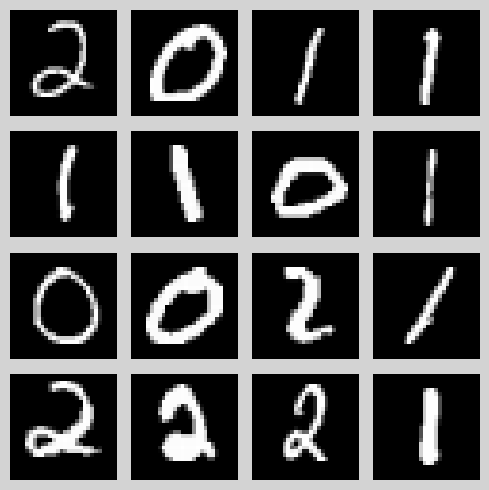

In [39]:
digits = [0,1,2]

A_test, A_labels = generate_test(test, digits = digits, N = 800)
print("Test data shape: ", A_test.shape) # Should be (784,2400)
print("Test labels shape: ", A_labels.shape) # Should be (2400)
print("First 16 labels: ", A_labels[:16])
plotimgs(A_test, nplot = 4)

## a)

Implementerer en funksjon som tar inn et testdatasett (matrise $B$) og en liste med dictionaries (basiser). Den projiserer testdataene på basisene og lagrer avstanden til hver basis. Deretter klassifiserer den hver av kolonnene i $B$ ved å finne bestemme hvilken basis kolonnen ligger nærmest. Funksjonen returnerer en vektor med anslåtte klasser til hver kolonne i $B$.

In [116]:
def classify(B, dict_list, dict_labels, dict_type, maxiter = 50, delta = 10**(-10)):
    """
    Beskrivelse:
    Forutsier klassen til hver kolonne i matrisen B
    -----
    Inputs: 
    B = Testdatasett, 2D matrise
    dict_labels = klasser til hver dictionary, like lang som antall dictionaries
    dict_list = liste med dictionaries, 1 dictionary = basis til et av tallene som skal klassifiseres
    dict_type = angir hva slags type dictionaries som tas inn (enten "orthogonal" eller "non-negative")
    -----
    Outputs:
    classified_data = predikert klasse til hvert testbilde, dvs. til hver kolonne i B
    """
    num_cols = B.shape[1] #antall kolonner i B
    num_dicts = len(dict_list) #antall dictionaries
    distances = np.zeros((num_cols, num_dicts)) #skal inneholde arrays med avstandene til hver basisvektor. hver rad tilsvarer en kolonne i B
    
    for i in range(num_dicts):
        dictionary = dict_list[i]  #henter ut en dictionary
        if dict_type == "orthogonal":
            B_dists = coloumnwise_distance(dictionary, B) #regner ut avstand fra hver kolonne i B til dictionarien
            
            for j in range(num_cols): #for hver kolonne i B
                distances[j][i] = B_dists[j]
                
        
        elif dict_type == "non-negative":
            B_dists = nndist(dictionary, B, maxiter = maxiter, delta = delta) #regner ut avstand fra hver kolonne i B til dictionarien
            
            for j in range(num_cols): #for hver kolonne i B
                distances[j][i] = B_dists[j]
    
    classified_data = np.zeros(num_cols) #anslåtte klasser til hver kolonne i B
    
    for n in range(num_cols):
        column_distances = distances[n] #avstandene til hver dict fra en kolonne i B
        predicted_label_index = np.argmin(distances[n]) #finner indeks til hvilken distionary som er nærmest 
        predicted_label = dict_labels[predicted_label_index]
        classified_data[n] = predicted_label 
    
    return classified_data

## b)

Vi lager nå et testdatasett som inneholder sifrene $1$, $3$ og $7$. Deretter henter vi ut treningsdata for hvert siffer (`A_train_1`, `A_train_3` og `A_train_7`). Her har vi har valgt å brukte $1000$ bilder av hvert siffer å trene på. Totalt er det $3000$ bilder i treningssettet. Vi lager så en basis for hvert siffer med både SVD og ENMF.  

Ved å bruke klassifiseringsfunksjonen fra forrige oppgave, finner vi først de predikerte klassene for bildene i testsettet med SVD, og lagrer dem i lista `SVD_pred`. Vi gjør tilsvarende med ENMF, og lagrer klassene i `ENMF_pred`.

In [41]:
# Genererer testsett med tallene 1, 3 og 7
test_imgs, test_labels = generate_test(test, digits = [1,3,7], N = 800)

# Henter ut treningsdata
n = 1000 # Antall datapunkter
A_train_1 = train[:, 1, :n] # Data for n bilder av 1-tall
A_train_3 = train[:, 3, :n] # Data for n bilder av 3-tall
A_train_7 = train[:, 7, :n] # Data for n bilder av 7-tall

# Liste med hvilke tall som er i datasettet
dict_labels = [1, 3, 7] 

#Antall basisvektorer per dictionary
d = 32 

# Lager SVD-dictionaries
U_test1, Sig_test1, Vt_test1 = np.linalg.svd(A_train_1, full_matrices = False)
U_test3, Sig_test3, Vt_test3 = np.linalg.svd(A_train_3, full_matrices = False)
U_test7, Sig_test7, Vt_test7 = np.linalg.svd(A_train_7, full_matrices = False)

SVD_dict_1 = truncSVD(U_test1,Sig_test1,Vt_test1, d)[0]
SVD_dict_3 = truncSVD(U_test3,Sig_test3,Vt_test3, d)[0]
SVD_dict_7 = truncSVD(U_test7,Sig_test7,Vt_test7, d)[0]

# Liste med én dictionary for hvert siffer i testsettet
SVD_list = [SVD_dict_1, SVD_dict_3, SVD_dict_7] 

# Lager ENMF-dictionaries
ENMF_dict_1 = ENMF_dicts(A_train_1, d)[1]
ENMF_dict_3 = ENMF_dicts(A_train_3, d)[1]
ENMF_dict_7 = ENMF_dicts(A_train_7, d)[1]

# Liste med én dictionary for hvert siffer i testsettet 
ENMF_list = [ENMF_dict_1, ENMF_dict_3, ENMF_dict_7] 

# Klassifiserer testmatrisen med SVD
SVD_pred32 = classify(test_imgs, SVD_list, dict_labels, "orthogonal")

# Klassifiserer testmatrisen med ENMF
ENMF_pred32 = classify(test_imgs, ENMF_list, dict_labels, "non-negative")


Nå vil vi finne ut av hvor gode prediksjonene er. Dette gjør vi med funksjonen `accuracy`, som er definert under. Den går igjennom hver label i en liste med prediksjoner, og sammenligner den med den faktiske klassen til bildet. Funksjonen returnerer andel rette prediksjoner, samt et array med andel rette prediksjoner per klasse.  

In [142]:
# Sjekker at prediksjoner og de faktiske klassene til testdataene har lik lengde
print(SVD_pred32.shape)
print(ENMF_pred32.shape)
print(test_labels.shape)

#Lager en funksjon for å regne ut accuracy
def accuracy(predictions, test_labels):
    """
    -----
    Inputs: 
    predictions = array med klassifiserte klasser til testsettet
    test_labels = array med faktiske klasser
    -----
    Outputs:
    accuracy = andel rette klassifiseringer
    accuracy_per_class = array med andel rette klassifiseringer per klasse, sortert etter klasse i stigende rekkefølge
    -----
    Beskrivelse:
    Tester nøyaktigheten av klassifisering
    """

    num_of_test_imgs = len(test_labels)  #antall testbilder
    num_right_predicts = 0 #antall riktige prediksjoner
   

    unique_test_labels, imgs_per_label_test = np.unique(test_labels, return_counts=True)
    #unique_test_labels: liste med unike klasser i testsettet, stigende rekkefølge
    #imgs_per_label: antall forekomster av hver klasse i testsettet
    
    count_dict = {} #tom dictionary. Skal inneholde unike klasser som nøkler, og antall rette klassifiseringer av hver klasse som verdier

    for i in range(num_of_test_imgs):
        label = test_labels[i]
        if predictions[i] == label:
            num_right_predicts += 1
            if label not in count_dict:
                count_dict[label] = 1
            else:
                count_dict[label] += 1

    ordered_dict = sorted(count_dict.items()) #sorterer dictionarien i stigende rekkefølge
    right_preds_per_class = np.array(list(dict(ordered_dict).values())) #konverterer verdiene til den sorterte dictionarien til et numpy-array
    
    accuracy = num_right_predicts/num_of_test_imgs #total andel riktige klassifiseriger
    recall = right_preds_per_class/imgs_per_label_test #andel riktige klassifiseringer per klasse
    
    return accuracy, recall

(2400,)
(2400,)
(2400,)


In [141]:
#Skriver ut treffsikkerheten til anslagene 
SVD_acc32, SVD_recall32 = accuracy(SVD_pred32, test_labels)
ENMF_acc32, ENMF_recall32 = accuracy(ENMF_pred32, test_labels)

print(f"SVD har total accuracy lik {SVD_acc32:.4f}")
print(f"SVD, andel rette prediksjoner for hvert siffer {dict_labels}: {SVD_recall32}")
print('\n')
print(f"ENMF har total accuracy lik {ENMF_acc32:.4f}")
print(f"ENMF, andel rette prediksjoner for hvert siffer {dict_labels}: {ENMF_recall32}")

SVD har total accuracy lik 0.9850
SVD, andel rette prediksjoner for hvert siffer [1, 3, 7]: [0.99375 0.98625 0.975  ]


ENMF har total accuracy lik 0.9696
ENMF, andel rette prediksjoner for hvert siffer [1, 3, 7]: [0.985   0.9775  0.94625]


Ved å sammenligne hhv. `SVD_pred` og `ENMF_pred` med testsettets faktiske klasser (lagret i `test_labels`), får vi at dataene blir klassifisert rett ca. $98.5 \%$ av gangene med en SVD-basis, og ca. $96.8 \%$ av gangene med en ENMF-basis. Disse tallene avhenger selvfølgelig av kjøringen (testdatasettet blir generert tilfeldig ved hver kjøring). Vi ser altså at begge metodene gir en høy grad av nøyaktighet med $d = 32$ basisvektorer, men det er derimot litt uklart vi om kan konkludere med at en metode er bedre enn den andre basert på denne ene kjøringen.

For både SVD og ENMF var det enklest å klassifisere $1$-tallet, mens $7$-tallet ble oftest feilklassifisert. SVD-metoden er mest presis for alle tre sifrene. 

For å teste om tendensene fra denne kjøringen virker å gjelde generelt, tester vi ut metodene vi har brukt ved å variere antall basisvektorer. I neste kodeblokk bruker vi $d = 10$ og $d = 400$.


In [43]:
#lager SVD-dictionaries

# d = 10
SVD_dict_1_10 = truncSVD(U_test1,Sig_test1,Vt_test1, 10)[0]
SVD_dict_3_10 = truncSVD(U_test3,Sig_test3,Vt_test3, 10)[0]
SVD_dict_7_10 = truncSVD(U_test7,Sig_test7,Vt_test7, 10)[0]

# d = 400
SVD_dict_1_400 = truncSVD(U_test1,Sig_test1,Vt_test1, 400)[0]
SVD_dict_3_400 = truncSVD(U_test3,Sig_test3,Vt_test3, 400)[0]
SVD_dict_7_400 = truncSVD(U_test7,Sig_test7,Vt_test7, 400)[0]

#lager SVD-lister
SVD_list_10 = [SVD_dict_1_10, SVD_dict_3_10, SVD_dict_7_10]
SVD_list_400 = [SVD_dict_1_400, SVD_dict_3_400, SVD_dict_7_400]


#lager ENMF-dictionaries

# d = 10
ENMF_dict_1_10 = ENMF_dicts(A_train_1, 10)[1]
ENMF_dict_3_10 = ENMF_dicts(A_train_3, 10)[1]
ENMF_dict_7_10 = ENMF_dicts(A_train_7, 10)[1]

# d = 400
ENMF_dict_1_400 = ENMF_dicts(A_train_1, 400)[1]
ENMF_dict_3_400 = ENMF_dicts(A_train_3, 400)[1]
ENMF_dict_7_400 = ENMF_dicts(A_train_7, 400)[1]

#Lager ENMF-lister
ENMF_list_10 = [ENMF_dict_1_10, ENMF_dict_3_10, ENMF_dict_7_10]
ENMF_list_400 = [ENMF_dict_1_400, ENMF_dict_3_400, ENMF_dict_7_400]

#Klassifiserer testmatrisen med SVD
SVD_pred10 = classify(test_imgs, SVD_list_10, dict_labels, "orthogonal")
SVD_pred400 = classify(test_imgs, SVD_list_400, dict_labels, "orthogonal")

#Klassifiserer testmatrisen med ENMF
ENMF_pred10 = classify(test_imgs, ENMF_list_10, dict_labels, "non-negative")
ENMF_pred400 = classify(test_imgs, ENMF_list_400, dict_labels, "non-negative")

#Regner ut accuracy
SVD_acc10, SVD_recall10 = accuracy(SVD_pred10, test_labels)
SVD_acc400, SVD_recall400 = accuracy(SVD_pred400, test_labels)
ENMF_acc10, ENMF_recall10 = accuracy(ENMF_pred10, test_labels)
ENMF_acc400, ENMF_recall400 = accuracy(ENMF_pred400, test_labels)

Lager tabell over dataene.

In [143]:
data = {
        'Type': ["SVD", "SVD", "SVD", "ENMF", "ENMF",  "ENMF"],
        'd': [10, 32, 400, 10, 32, 400],
        'Class 1':[SVD_recall10[0], SVD_recall32[0], SVD_recall400[0],ENMF_recall10[0], ENMF_recall32[0], ENMF_recall400[0]],
        'Class 3':[SVD_recall10[1], SVD_recall32[1], SVD_recall400[1],ENMF_recall10[1], ENMF_recall32[1], ENMF_recall400[1]],
        'Class 7':[SVD_recall10[2], SVD_recall32[2], SVD_recall400[2],ENMF_recall10[2], ENMF_recall32[2], ENMF_recall400[2]],
        'Total accuracy':[SVD_acc10, SVD_acc32, SVD_acc400, ENMF_acc10, ENMF_acc32, ENMF_acc400]
        }

df = pd.DataFrame(data)
df.groupby(['Type', 'd'])
df.loc['Average'] = pd.Series(df[['Class 1', 'Class 3', 'Class 7', 'Total accuracy']].mean(), index=['Class 1', 'Class 3', 'Class 7', 'Total accuracy'])

print(df)
print('\n')
print(f"Average accuracy SVD: {((SVD_acc10+ SVD_acc32+ SVD_acc400)/3):.3f}")
print(f"Average accuracy ENMF: {((ENMF_acc10+ ENMF_acc32+ ENMF_acc400)/3):.3f}")

         Type      d   Class 1   Class 3   Class 7  Total accuracy
0         SVD   10.0  0.997500  0.983750  0.965000        0.982083
1         SVD   32.0  0.993750  0.986250  0.975000        0.985000
2         SVD  400.0  0.988750  0.716250  0.880000        0.861667
3        ENMF   10.0  0.992500  0.962500  0.901250        0.952083
4        ENMF   32.0  0.985000  0.977500  0.946250        0.969583
5        ENMF  400.0  0.993750  0.988750  0.978750        0.987083
Average   NaN    NaN  0.991875  0.935833  0.941042        0.956250


Average accuracy SVD: 0.943
Average accuracy ENMF: 0.970


For SVD ser vi at å øke antall basisvektorer fra 10 til 32 gjør at treffsikkerheten nærmest er uendret (og høy - drøyt 98 %), men treffsikkerheten avtar med over 10 % når vi øker $d$ til 400. Årsaken til dette diskuterer vi grundigere i oppgave 3f). 

For ENMF blir treffsikkerheten litt bedre etter hvert som vi øker antall basisvektorer (se 3f her også), og den avtar ikke selv om vi bruker en stor $d$.

SVD gir en litt høyere treffsikkerhet enn ENMF ved lavt antall basisvektorer, mens ENMF gir en signifikant høyere treffsikkerhet ved $d = 400$. 

Med begge metodene var 1-tallet lettest å klassifisere, mens 7-tallet var vanskeligst å klassifisere. Dette er nok fordi 1-tallet har en enkel form og derfor er enkel å gjenkjenne, mens 7-tallet lett kan forveksles med et 1-tall. Merknad: Klasse-gjennomsnittet i tabellen over sier likevel at 3-tallet var vanskeligst å klassifisere - dette er grunnet en avvikende verdi vi fikk for SVD med $d$ = 400, som trakk snittet for denne klassen ned. Her fikk vi en accuracy på 0.7, vi har ikke en god forklaring på hvorfor.

## c)

Plotter det bildet som er mest sannsynlig til å inneholde heltallet $3$ fra testsettet. Dette bildet er nærmest basisen til $3$ ved SVD-tilnærmingen. Plotter dette bildet med projeksjonen bildet har på denne basisen.  

In [45]:
# Går gjennom alle treningsbildene av siffer i A_train_3 bruker colomwise_distance til å finne
# alle avstander fra hvert enkelt bilde til basisen SVD_dict_3
distances = np.zeros(np.shape(A_train_3)[1])
for i in range(np.shape(A_train_3)[1]):
    distances[i] = coloumnwise_distance(SVD_dict_3, A_train_3[:, i])

B_min = np.argmin(distances) #Pixelverdier nummer B_min i A_train_3 som ligger nærmest basisen SVD_dict_3

(-0.5, 27.5, 27.5, -0.5)

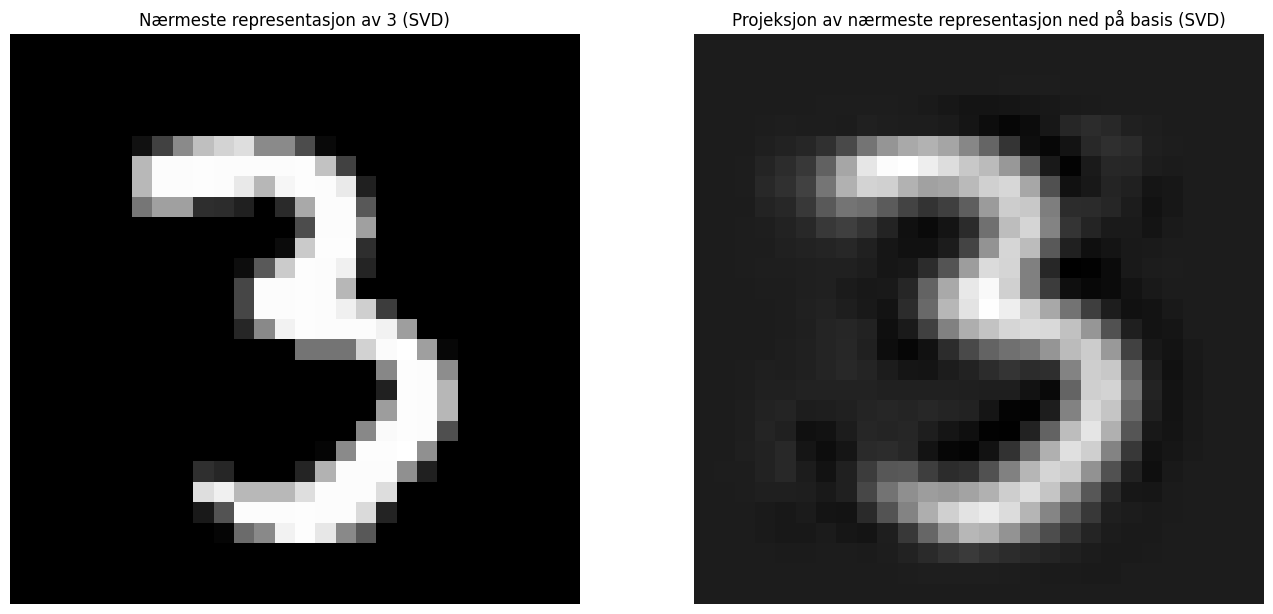

In [46]:
fig = plt.figure(figsize=(25, 25))

# Plotter den nærmeste representasjonen av 3 ved SVD
ax = fig.add_subplot(131, title='Nærmeste representasjon av 3 (SVD)', aspect='equal')
Near = ax.imshow(A_train_3[:, B_min].reshape((28,28)), cmap = 'gray')
plt.axis('off')

#Plotter projeksjonen av nærmeste representasjon ned på basisen ved SVD
ax = fig.add_subplot(132, title='Projeksjon av nærmeste representasjon ned på basis (SVD)', aspect='equal')
Projec = ax.imshow(orthproj(SVD_dict_3, A_train_3[:, B_min]).reshape((28,28)), cmap = 'gray')
plt.axis('off')

Vi ser at den nærmeste representasjonen av $3$ ved SVD er en god representasjon av hvordan et $3$-tall ser ut. Dette bildet er nærmest basisen vi projiserer på så projeksjonen burde bli ganske lik originalbildet. Her er det bare brukt $d = 32$ basisvektorer så projeksjonen blir noe uklar, men vi kan se at det representerer formen på det opprinnelige $3$-tallet godt. 

## d)

Velger et bilde fra klassen $3$ som avviker sterkt fra resten av datasettet. Denne "outlieren" vil ligge lengst unna basisen til $3$.

(-0.5, 27.5, 27.5, -0.5)

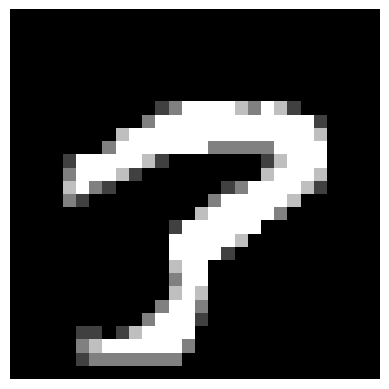

In [47]:
# Bildet som avviker mest fra klassen 3
B_max = np.argmax(distances)
plt.imshow(A_train_3[:, B_max].reshape((28,28)), cmap = 'gray')
plt.axis('off')

Den største forskjellen mellom det bildet som avviker mest og bildet som representerer klassen $3$ best er den nederste delen av heltallet $3$. "Outlieren" gir en dårlig representasjon av den nederste buen av på tallet. Dette kan klassifisere bildet feil da egenskapene likner noe mer på heltallet $7$. Det blir da vanskeligere å fange opp hvilken klasse bildet tilhører enn for bildet som representerer klassen $3$ best, hvor det er lettere å fange opp de karakteristiske egenskapene til tallet.

## e)
Genererer et nytt datasett som inneholder samme tall som i b) og heltallet $8$, og klassifiserer dataene.

In [48]:
# Genererer testsett med tallene 1, 3 og 7
test_imgs_new, test_labels_new = generate_test(test, [1,3,7,8], N = 800)

# KLASSIFISERER DATAENE

# Henter ut treningsdata
n = 1000 # Antall datapkt
A_train_8 = train[:, 8, :n] # Data for n bilder av 8-tall

dict_labels_new = [1, 3, 7, 8] # Liste med hvilke tall som er i datasettet

d = 32 # Antall basisvektorer per dictionary

# Lager SVD-dictionary
U_test_8, Sig_test_8, Vt_test_8 = np.linalg.svd(A_train_8, full_matrices = False)

SVD_dict_8 = truncSVD(U_test_8, Sig_test_8, Vt_test_8, d)[0]

# Liste med én dictionary for hvert siffer i testsettet
SVD_list_new = [SVD_dict_1, SVD_dict_3, SVD_dict_7, SVD_dict_8] 

# Lager ENMF-dictionary
ENMF_dict_8 = ENMF_dicts(A_train_8, d)[1]

# Liste med en dictionary for hvert siffer i testsettet
ENMF_list_new = [ENMF_dict_1, ENMF_dict_3, ENMF_dict_7, ENMF_dict_8] 

# Klassifiserer testmatrisen med SVD
SVD_pred_new = classify(test_imgs_new, SVD_list_new, dict_labels_new, "orthogonal")

# Klassifiserer testmatrisen med ENMF
ENMF_pred_new = classify(test_imgs_new, ENMF_list_new, dict_labels_new, "non-negative")

Nå vil vi igjen finne ut av hvor nøyaktige prediksjonene er.

In [55]:
# Skriver ut treffsikkerheten til anslagene 
SVD_acc_new, SVD_recall_new = accuracy(SVD_pred_new, test_labels_new)
ENMF_acc_new, ENMF_recall_new = accuracy(ENMF_pred_new, test_labels_new)

print(f"SVD har nå total accuracy lik {SVD_acc_new}")
print(f"SVD, andel rette prediksjoner for hvert siffer {dict_labels_new}: {SVD_recall_new}")
print('\n')
print(f"ENMF har nå total accuracy lik {ENMF_acc_new}")
print(f"ENMF, andel rette prediksjoner for hvert siffer {dict_labels_new}: {ENMF_recall_new}")

SVD har nå total accuracy lik 0.9703125
SVD, andel rette prediksjoner for hvert siffer [1, 3, 7, 8]: [0.99375 0.96125 0.97375 0.9525 ]


ENMF har nå total accuracy lik 0.9403125
ENMF, andel rette prediksjoner for hvert siffer [1, 3, 7, 8]: [0.985   0.955   0.93375 0.8875 ]


Lager også tabell over de nye dataene.

In [56]:
data_new = {
        'Type': ["SVD", "ENMF"],
        'd': [32, 32],
        'Class 1':[SVD_recall_new[0], ENMF_recall_new[0]],
        'Class 3':[SVD_recall_new[1], ENMF_recall_new[1]],
        'Class 7':[SVD_recall_new[2], ENMF_recall_new[2]],
        'Class 8':[SVD_recall_new[3], ENMF_recall_new[3]],
        'Total accuracy':[SVD_acc_new, ENMF_acc_new]
        }

df_new = pd.DataFrame(data_new)
df_new.groupby(['Type', 'd'])
df_new.loc['Average'] = pd.Series(df_new[['Class 1', 'Class 3', 'Class 7', 'Class 8', 'Total accuracy']].mean(), index=['Class 1', 'Class 3', 'Class 7', 'Class 8', 'Total accuracy'])

print(df_new)

         Type     d   Class 1   Class 3  Class 7  Class 8  Total accuracy
0         SVD  32.0  0.993750  0.961250  0.97375   0.9525        0.970313
1        ENMF  32.0  0.985000  0.955000  0.93375   0.8875        0.940312
Average   NaN   NaN  0.989375  0.958125  0.95375   0.9200        0.955313


Her observeres det at klassene ved SVD ikke endrer særlig nøyaktighet fra deloppgave 3b). Dette stemmer godt overens med at metoden SVD alltid bruker de $d = 32$ første basisvektorene i dictionarien som inneholder mest data, så nøyaktigheten endres ikke selv om den utføres på nytt. Vi ser likevel at treffsikkerheten i klasse $3$ går noe ned. Den totale nøyaktigheten blir derimot lavere, da det er en ekstra klasse å klassifisere feil til. Dette stemmer godt med at det er klasse $3$ som minker mest i nøyaktighet, da dette tallet likner mest på $8$. I tillegg ser vi i tabellen at tallet 8 er vanskeligere å klassifisere enn de andre klassene, og vil dette derfor derfor dra den totale nøyaktigheten ned.

Når det gjelder resultatene ved ENMF er nøyaktigheten noe lavere her enn i deloppgave 3b). Dette kan komme av at ENMF-metoden velger $d = 32$ tilfeldige kolonner fra testdatasettet til dictionarien, så hvor mye data dictionarien inneholder kan variere. Her vil også den totale nøyaktigheten være noe lavere, da den ekstra klassen trekker ned nøyaktigheten sammenlagt. 

## f)
Vi vil nå gjøre et større eksperiment for å se på hvordan resultatene avhenger av mengden av basisvektorer $d$ i dictionarien. For $d = 2^{i}$, der $i = 1, ... , 10$, lages og klassifiseres dictionaries som alle inneholder $d$ basisvektorer, samt nøyaktigheten av klassifikasjonen. Plotter denne nøyaktigheten mot antall basisvektorer $d$ for både SVD og ved ENMF-tilnærmingen. 
Starter med å skrive om `truncSVD` og `ENMF_dicts` til å lage en full liste med alle dictionaries for et gitt antall siffer som vil trenes og testes for. Ved å skrive nye funksjoner, sparer man kompileringstid ved å unngå å kalkulere noen faktorer som projeksjon i `ENMF_dicts`.

In [51]:
# Definerer funksjoner som lager en "dictionary" for M antall siffer med d kolonner for alle test dataene

def multi_SVD_dicts(digetList, d_colums, n_data = 1000):
    """
    -----
    Inputs: 
    digetList = [list] liste med hvilke siffer som skal brukes
    d_colums = [int] antall basisvektrorer som skal brukes
    n_data = [int] antall datapunkter per siffer som skal brukes (standard = 1000)
    -----
    Outputs:
    SVD_list = [list] Liste med med dictionaries for alle siffer med gitt antall basisvektorer
    -----
    Beskrivelse:
    Lager en liste hvor hvert element er en SVD dictionaries for et siffer. Alle har samme antall basisvektorer

    """
    SVD_list = []
    for i in range(len(digetList)):
        U, Sigma, Vt = np.linalg.svd(train[:,digetList[i],:n_data], full_matrices = False)
        SVD_list.append(truncSVD(U, Sigma, Vt, d_colums)[0])
    return SVD_list

def multi_ENMF_dicts(digetList, d_colums, n_data = 1000, delta = 10**(-10), maxiter = 50):
    """
    -----
    Inputs: 
    digetList = [list] liste med hvilke siffer som skal brukes
    d_colums = [int] antall basisvektrorer som skal brukes
    n_data = [int] antall datapunkter per siffer som skal brukes (standar = 1000)
    delta = [float] verdi for delta? 
    maxiter = [int] max antall iterasjoner som skal gjøres for å generer en ENMF_dict
    -----
    Outputs:
    ENMF_list = [list] Liste med dictionaries for alle siffer med gitt antall basisvektorer
    -----
    Beskrivelse:
    Lager en liste hvor hvert element er en ENMF dictionaries for et siffer. Alle har samme antall basisvektorer
    """
    ENMF_list = []
    for i in range(len(digetList)):
        W = np.zeros((784, d_colums))
        A = train[:,digetList[i],:n_data]
        rand_indexes = np.random.choice(train[:,digetList[i],:n_data].shape[1],d_colums, replace=False)
        for k in range(len(rand_indexes)):
            W[:, k] = A[:, rand_indexes[k]]
        ENMF_list.append(W)
    return ENMF_list

In [162]:
def SVD_and_ENMF_accuracy(digits, d_colums, dict_labels, test_imgs_all, test_labels_all, n_data = 1000):
    """
    -----
    Inputs: 
    digits = [list] liste med hvilke siffer som skal brukes
    d_colums = [int] antall basisvektrorer som skal brukes
    dict_labels = [list] liste med siffer som accuracy skal testes på
    test_imgs_all = bildene hentet ut av test.npy som skal klassifiseres
    test_labels_all = verdi for hvert test image i test_imgs_all
    n_data = [int] antall datapunkter per siffer som skal brukes (standar = 1000)
    -----
    Outputs:
    SVD_acc_multi_d = [list] Liste med gjennomsnittlig treffsikkerhet for gitte antall basisvektorer
    ENMF_acc_multi_d = [list] Liste med gjennomsnittlig treffsikkerhet for gitte antall basisvektorer
    -----
    Beskrivelse:
    Regner ut gjennomsnittlig treffsikkerhet for SVD og ENMF for et gitt antall siffer for forskjellig antall basisvektorer
    """
    SVD_acc_multi_d = np.zeros(len(d_colums))
    ENMF_acc_multi_d = np.zeros(len(d_colums))

    for i in trange(0, len(d_colums)): # Bruker trange for å få en progress bare 
                                       # for estimat på hvor lenge som er igjen av løkka
        # Generer SVD dictionary for d_colums[i]
        SVD_dict_all = multi_SVD_dicts(digits, d_colums[i], n_data = n)
        # Finner SVD antagelse og treffiskkerhet
        SVD_pred_all = classify(test_imgs_all, SVD_dict_all, dict_labels, "orthogonal")
        SVD_acc_all = accuracy(SVD_pred_all, test_labels_all)[0]

        # Generer ENMF dictionary for d_colums[i]
        ENMF_dict_all = multi_ENMF_dicts(digits, d_colums[i], n_data = n, delta = 10**(-2))
        # Finner ENMF antagelse og treffiskkerhet
        ENMF_pred_all = classify(test_imgs_all, ENMF_dict_all, dict_labels, "non-negative", delta = 10**(-2), maxiter=50)
        ENMF_acc_all = accuracy(ENMF_pred_all, test_labels_all)[0]

        # Setter alle treffiskkerhetene for hver menge basisvektorer inn i en liste
        SVD_acc_multi_d[i] = SVD_acc_all
        ENMF_acc_multi_d[i] = ENMF_acc_all            
          
    return SVD_acc_multi_d, ENMF_acc_multi_d  


Vi tester nå treffsikkerheten for både SVD og ENMF for et forskjellig antall basisvektorer.

In [159]:
digits = [0,1,2,3,4,5,6,7,8,9]
test_imgs_all, test_labels_all = generate_test(test, digits, N = 800)

# Liste med hvilke tall som er i datasettet
dict_labels_all = digits

# Lager en liste med med økende antall basisvektorer økene med 2^i og flere verdier mellom 512 og 748
d_large_vals = [2, 4, 8, 16, 32, 64, 128, 256, 512, 580, 630, 700, 740]
print(d_large_vals)

[2, 4, 8, 16, 32, 64, 128, 256, 512, 580, 630, 700, 740]


In [160]:
n = 5000 # Antall data per siffer for trening (All treningsdata)
# Henter ut listene for gjennomsnittlig SVD og ENMF utifra et gitt antall basisvektorer
SVD_acc_multi_d, ENMF_acc_multi_d = SVD_and_ENMF_accuracy(digits, d_large_vals, dict_labels_all, test_imgs_all, test_labels_all, n_data = n)

100%|██████████| 13/13 [11:56<00:00, 55.13s/it]


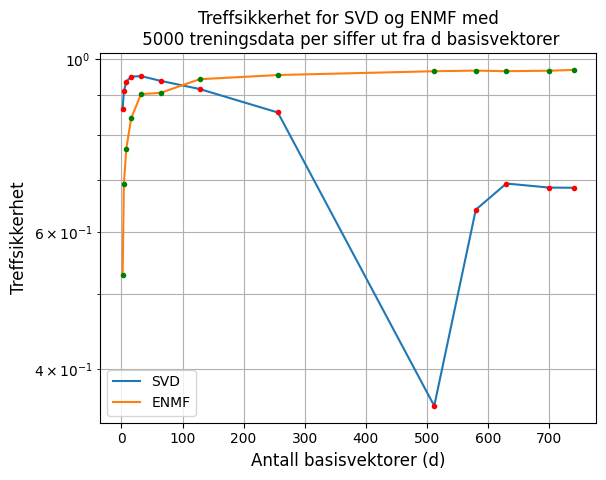

In [161]:
# Plotter antall basisvektorer mot SVD treffsikkerhet
plt.semilogy(d_large_vals, SVD_acc_multi_d, label="SVD") # denne funker
plt.plot(d_large_vals, SVD_acc_multi_d, 'o', color='red', markersize=3)

# Plotter antall basisvektorer mot ENMF treffsikkerhet
plt.semilogy(d_large_vals, ENMF_acc_multi_d, label="ENMF")
plt.plot(d_large_vals, ENMF_acc_multi_d, 'o', color='green', markersize=3)

plt.title(f"Treffsikkerhet for SVD og ENMF med\n {n} treningsdata per siffer ut fra d basisvektorer", fontsize=12)
plt.xlabel("Antall basisvektorer (d)", fontsize=12)
plt.ylabel("Treffsikkerhet", fontsize=12)
plt.grid(True, which="both")
plt.legend()
plt.show()

Vi ser at for en lav $d$ er treffsikkerheten for SVD god, mens for ENMF er den mye dårligere. Dette kommer av at ved SVD inneholder dictionarien med de $d$ basisvektorene som inneholder mest data, mens ENMF velger $d$ tilfeldige basisvektorer. De tilfeldige basisvektorene inneholder da ikke nødvendigvis nok data til å klassifisere riktig. Dette endrer seg ved hver kjøring av koden da $d$ nye basisvektorer velges, men mest sannsynlig (som stemmer ved denne kjøringen) vil treffsikkerheten være dårlig ved en lav $d$ for ENMF. 

Når $d$ øker vil treffsikkerheten for SVD først øke da vi inkluderer enda flere basisvektorer med mye data, noe vi så i 2c). Når vi derimot nærmer oss rundt $64$ basisvektorer minker treffsikkerheten av klassifiseringen. Dette kommer av at vi tar med fler og fler basisvektorer som inneholder uviktig data (støy) som gjør at vi rekonstruerer bildet feil. Dette så vi 1a). Dette kan forstyrre klassifiseringen da den fanger opp karakteristiske egenskaper på heltallsbildene som ikke er viktige, fordi de viktigste egenskapene ligger lagret i de første basisvektorene. Ved $512$ basisvektorer øker treffsikkerheten igjen. Dette kan komme av at de basisvektorene som ikke er inkludert nå samsvarer med singulærverdi $0$, som vi med trygghet kan ekskludere som vi så i 1b). At dette skjer ved rundt $512$ stemmer godt overens med når singulærverdiene ble $0$ i plottet i 2b). Det er likevel litt forstyrrelser av de overflødige basisvektorene (på grunn av flyttallsfeil) så vi oppnår bare en treffsikkerhet på litt under $70 \%$ når vi bruker $5000$ treningsdata per siffer. Videre minker treffsikkerheten igjen, også på grunn av flere inkluderte overflødige basisvektorer. 

For ENMF øker treffsikkerheten med $d$. Dette kommer av at vi hele tiden inkluderer nye, tilfeldige basisvektorer som gjør at det bedre og bedre fanges opp karakteristiske egenskaper ved heltallsbildene. I motsetning til SVD vil bildet rekonstrueres bare bedre og bedre, da vi inkludere fler og fler faktiske basisvektorer fra datasettet. Derfor vil treffsikkerheten til ENMF bare fortsette å øke.

Sammenliknet med oppgave 2e) så er treffsikkerheten ved $d = 32$ ganske lik, men noe lavere her da vi klassifiserer alle $10$ klassene der treffsikkerheten til hver klasse må tas hensyn til. 




## Konklusjon

#### Hva har vi lært?

"Dictionary learning" er en teknikk der man lager et sett med lineære basisvektorer fra et stort datasett, og bruker disse til å rekonstruere eller klassifisere lignende data som finnes i datasettet. I dette prosjektet har vi brukt to forskjellige metoder for å lage slike basiser. 

Den ene metoden kalles "Singular Value Decomposistion" (SVD), der man dekomponerer en matrise $A$ med datasettet til tre matriser $U \Sigma V^T$, der $U$ er basis-settet. 
Den andre metoden kalles "Exemplar-based Non-negative Matrix Factorization" (ENMF). Med ENMF får man en basis ved å tilfeldig velge et visst antall datapunkter fra datasettet som basisvektorer. 

Vi har brukt disse metodene på MNIST-datasettet som består av bilder av håndskrevne sifre, og brukt dem til å rekonstruere noen bilder fra dette settet. Vi har også hentet inn noen test-bilder og klassifisert disse (forutsagt hvilket siffer som testbildet viser). Dette gjorde vi ved å finne avstanden fra testbildet til basiser for forskjellige sifre, og se hvilken av disse avstandene som var minst. Den basisen som testbildet ligger nærmest, tilhører det sifferet som bildet mest sannsynlig viser.



#### Sammenligning av SVD og ENMF


Basisvektorene i $U$-dictionarien vi får fra SVD, sammen med singulærverdiene til $\Sigma$ er begge sortert fra størst til minst (og derfor fra mest til minst viktig) fra venstre. Med en dictionary som er trent på et gitt heltall, øker kvaliteten på rekonstruksjonen av et bilde av dette heltallet med økende $d$ i starten, fordi vi inkluderer flere av de viktige basisvektorene. Hvis vi forsetter å øke $d$, vil rekonstruksjonen etter et visst punkt bli dårligere, fordi vi inkluderer for mange uviktige basisvektorer, som bare bidrar til støy og ikke gir noen informasjon om viktige karakteristikker som skiller det valgte heltallet fra et annet heltall. Dette fører også til dårligere treffsikkerhet når vi skal klassifisere testdata.

Om vi heller projiserer et siffer på dictionarien som denne ikke er trent på, vil rekonstruksjonen ved lave $d$ likne sifferet dictionarien er trent på - ikke sifferet som skal rekonstrueres. Det er likevel mulig å få en brukbar rekonstruksjon ved en høy nok $d$.

Ved bruk av ENMF-dictionarier, får vi bedre rekonstruksjoner jo flere basisvektorer vi bruker, og også bedre treffsikkerhet ved klassifisering av testdata. Denne treffsikkerheten er lavere enn for SVD ved små $d$, men er langt bedre ved store $d$. Rekonstruksjoner ved bruk av ENMF har skarpere kontraster enn ved SVD, siden de er laget av faktiske bilder i datasettet, og inneholder ikke støy fra numeriske feil. 

De to metodene, SVD og ENMF, utføres forskjellig og har da ulike fordeler og ulemper. Fordeler ved SVD er at det kreves færre antall basisvektorer for å få god treffsikkerhet. Dette er en fordel da prosesseringstiden er raskere. Ettersom ENMF heller bruker tilfeldige basisvektorer fra datasettet til å lage dictionarien, kreves det flere basisvektorer for å oppnå god treffsikkerhet. Dette er en ulempe da det har en lengre prosesseringstid. Der ENMF blir bedre med økene antall basisvektorer, blir SVD verre grunnet mye overflødig informasjon. SVD vil være god til bruk på mindre datasett der man kan spesifisere et gitt antall basisvektorer. ENMF vil derimot også fungere godt på større datasett, der den kontinuerlig vil rekonstruere gode resultatere selv om vi tar inn mer av datasettet (øker antall basisvektorer). Ulempen er som sagt at prosesseringstiden øker også.

#### Dictionary learning som tilnærming
"Dictionary learning" som tilnærming er god til bruk på tolkning av data. Problemet er at den er lite dynamisk. Grunnen til dette er at vi setter en basis når vi "trener" dictionarien. Dette er et problem, da vi har en begrenset mengde informasjon som er satt allerede ved start. Optimalt ville det være bedre om man kunne få programmet til å selv endre på basisvektorene sine i tilfeller der den klassifisert sifre feil. Ved å kunne ta i bruk dette vil man kunne sikre en gjennomsnittlig bedre treffsikkerhet. I en videreføring av prosjektet kunne vi forsøkt å implementere dette for å øke treffsikkerheten uten å øke prosesseringstiden, da det ville vært mulig å justere på verdiene til basisvektorene uten å øke antallet basisvektorer.

## Kilder
[1] M. Ludvigsen, (19. februar 2023). "TMA4320 vår 2023 - Industriell Matematikk-Prosjekt": https://wiki.math.ntnu.no/_media/tma4320/2023v/tma4320_indmat_prosjekt_2023_3_.pdf

[2] M. Gavish og D. L. Donoho, (14. juni 2014) "The Optimal Hard Threshold for Singular Values is 4/√3": https://arxiv.org/pdf/1305.5870.pdf 

[3] Utdelt kode

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=21a3113f-99ab-42ed-9e9e-728ab9e98d59' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>